# CTC version 1




### Paper Reference
- [Connectionist Temporal Classification (IDSIA)](ftp://ftp.idsia.ch/pub/juergen/icml2006.pdf)


### English Test
First we test English



In [1]:
# Include And 
import sys
sys.path.append("/home/pika/nntools/")

import theano
import theano.tensor as T
import numpy as np
from theano_toolkit import utils as U
from theano_toolkit import updates
from theano.printing import Print
from theano_toolkit.parameters import Parameters

import lasagne
from lasagne.layers import *

from time import time

import ctc_cost_2

import cPickle
import sys
sys.setrecursionlimit(100000)

from random import shuffle

Using gpu device 0: GeForce GTX 980
/home/pika/nntools/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


# Data


In [2]:
'''
Doing : 
    - Read data and return x_test, y_test
'''
# TRAINING_ACOUSTIC_FEATURE = "./dataCebuano/train.f0_ffv_fbank.fea"
# TRAINING_ACOUSTIC_FEATURE = "./dataCebuano/train_Normalized_SELFVALID.ark"
# TRAINING_ACOUSTIC_FEATURE = "./dataCebuano/train_Normalized_SELFVALID_LenLessThen500.ark"
# TRAINING_LABELS = "./dataCebuano/train.txt"

# TESTING_ACOUSTIC_FEATURE = './dataCebuano/dev_Normalized_SELFVALID_originLength.ark'
TESTING_ACOUSTIC_FEATURE = './dataCebuano/tlkagk/large_dev.dnn.fea.lessThen500.ark'
TESTING_LABELS = './dataCebuano/tlkagk/large_dev.text'

CHAR_CORPUS = "./dataCebuano/corpus.txt"


def readDataSet () :
    
    # -- Mapping char to integer and reverse
    char_map = {}    # eg. { a -> 1 }
    char_unMap = {}  # eg. { 1 -> a }
    with open( CHAR_CORPUS, 'r' ) as f:
        char_index = 0
        for lines in f:
            char_map  [ lines[:-1] ] = char_index
            char_unMap[ char_index ] = lines[:-1]
            char_index += 1
        # add Blank, take '.' as blank (not space)
        char_map['.'] = char_index
        char_unMap[char_index] = '.'
    
    
    # -- Reading X = id -> [ list of feature ] 
    idMapX = {}
    idDeck = []
    id = ''
    
    tmp_l = 0;
    with open( TESTING_ACOUSTIC_FEATURE, 'r') as f:
        for lines in f: 
            if '[' in lines :
                id = lines.split(' ')[0]
                idDeck.append(id)
                idMapX[id] = []
            elif ']' in lines :
                if( len( lines.split('\n')[0].split(' ') [0:-1] ) != 90 ) :
                    print "err"
                    return 
                idMapX[id].append([float(x) for x in lines.split('\n')[0].split(' ') [:-1] ])
            else :
                if( len( lines.split('\n')[0].split(' ')) != 90 ):
                    print len( lines.split('\n')[0].split(' '))
                    print lines.split('\n')[0].split(' ')
                    print lines
                    print id
                    print "fuck"
                    return
                idMapX[id].append([float(x) for x in lines.split('\n')[0].split(' ') ])
    
    # Move to  3 - main - 3
    '''
    monoDimension = 33;
    zeroFeature = [0] * monoDimension
    #print len( zeroFeature ) 
    #print zeroFeature
    for id in idDeck:
        # print id
        tmpIdMapXWithID = []
        if len(idMapX[id]) < 6 :
            print "ERROR in length"
            return 
        for idxX in xrange( len(idMapX[id]) ):
            if idxX == 0:
                tmpIdMapXWithID.append( zeroFeature + zeroFeature + zeroFeature + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + idMapX[id][idxX+3] )    
            elif idxX == 1:
                tmpIdMapXWithID.append( zeroFeature + zeroFeature + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + idMapX[id][idxX+3] )  
            elif idxX == 2:
                tmpIdMapXWithID.append( zeroFeature + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + idMapX[id][idxX+3] )  
            elif idxX == (len(idMapX[id]) - 3 ):
                tmpIdMapXWithID.append( idMapX[id][idxX-3] + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + zeroFeature )  
            elif idxX == (len(idMapX[id]) - 2 ):
                tmpIdMapXWithID.append( idMapX[id][idxX-3] + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + zeroFeature + zeroFeature )  
            elif idxX == (len(idMapX[id]) - 1 ):
                tmpIdMapXWithID.append( idMapX[id][idxX-3] + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + zeroFeature + zeroFeature + zeroFeature )  
            else:
                tmpIdMapXWithID.append( idMapX[id][idxX-3] + idMapX[id][idxX-2] + idMapX[id][idxX-1] + idMapX[id][idxX] + idMapX[id][idxX+1] + idMapX[id][idxX+2] + idMapX[id][idxX+3] )  
        idMapX[id] = tmpIdMapXWithID
    
    print "Concate"
    '''
    # Standardlize X (Done in PrepreProcessing )
   
    id_test = idDeck
    
    idMapY = {} 
    
    checkPara = 0
    # -- Reading Y = id -> [ Sentence(list of char[int] ) ]
    with open( TESTING_LABELS, 'r') as f:
        specific = '?'
        for lines in f:
            yWithId = lines.split('\n')[0].split(' ', 1)
            idMapY[ yWithId[0] ] = []
            judgeSpecific = False
            for char in yWithId[1] :
                if char == '(' and checkPara == 0 : 
                    checkPara = 3
                elif checkPara > 0 :
                    checkPara -= 1
                    if checkPara == 0 :
                        idMapY[ yWithId[0] ].append( char_map[specific] )
                else :
                    if char == '<' :
                        judgeSpecific = True;                
                    if( judgeSpecific ):
                        if char == '>':
                            idMapY[ yWithId[0] ].append( char_map[specific] )
                            judgeSpecific = False
                    else :
                        if char == '*':
                            # print "detect *, do nothing think as a ?"
                            idMapY[ yWithId[0] ].append( char_map[specific] )
                        else :
                            idMapY[ yWithId[0] ].append( char_map[char.lower()] )
    
    # -- concatenate X and Y
    x_test = []
    y_test = []
    idCollect = []
    for id in id_test:
        concateId = []
        for i in range( len( idMapX[id] ) ) :
            concateId.append( idMapX[id][i] )
        x_test.append( floatX( concateId )  )
        y_test.append( floatX( idMapY[id]) )
        idCollect.append( id )
    
    print "Dataset Finish : "
    print "total x_test = " + str(len(x_test))
    print x_test[0]
    print "total y_test = " + str(len(y_test))
    print y_test[0]
    
    return char_map, char_unMap, x_test, y_test, idCollect

def floatX(x):
    return np.asarray(x, dtype=theano.config.floatX)

# Original 4381
# lessthen500 4157

char_map, char_unMap, x_test, y_test, idCollect = readDataSet()

Dataset Finish : 
total x_test = 9068
[[ 0.69503033  2.31900501  0.50183856 ..., -0.20260894  0.37641212
  -0.39681706]
 [ 0.6403448   2.49959922  0.36004975 ..., -0.43028951  0.81654525
  -1.07972169]
 [ 0.6332972   2.39799237  0.39283615 ..., -0.29196408  0.5189566
  -0.96880186]
 ..., 
 [-0.02676331  1.43714833 -0.03426567 ..., -0.07663634  0.12123411
  -0.90708876]
 [ 0.07852241  1.63102448 -0.10644515 ..., -0.11273394 -0.03324968
  -0.8224408 ]
 [ 0.11745473  1.50473654  0.1248449  ..., -0.03939926 -0.14081435
  -0.44900888]]
total y_test = 9068
[ 13.   8.  17.  17.  18.]


In [3]:
# 500 -> 3722 / 195
# 600 -> 3821 / 201
# 3000 -> 3937 / 207
print x_test[0].shape
print y_test[0].shape

(64, 90)
(5,)


In [4]:
len(x_test)

9068

In [5]:
print max( [X.shape[0] for X in x_test] )
print max( [Y.shape[0] for Y in y_test] )

501
138


In [6]:

'''
def make_batches_X(XLen, X, length, batch_size=30):
    n_batches = int(round(XLen*1./batch_size))
    X_batch = np.zeros( (n_batches, batch_size, length, X[0].shape[1]),
                       dtype=theano.config.floatX)
    X_mask  = np.zeros( (n_batches, length, batch_size ), 
                       dtype=theano.config.floatX)

    count = 0
    for b in range(n_batches): 
        for n in range(batch_size): # go thorough batch size
            
            if ( XLen > (b*batch_size + n )):
                count += 1
                
                X_m = X[b*batch_size + n] # seq_length X feature dim
                X_batch[b, n, :X_m.shape[0]] = X_m[:length]
                X_mask[b, :X_m.shape[0], n] = 1
    print count
            
    return X_batch, X_mask

'''

def make_batches_X(X, length, batch_size=30):
    n_batches = len(X)//batch_size
    X_batch = np.zeros( (n_batches, batch_size, length, X[0].shape[1]),
                         dtype=theano.config.floatX)
    X_mask  = np.zeros( (n_batches, length, batch_size ), 
                         dtype=theano.config.floatX)
    
    for b in range(n_batches): 
        for n in range(batch_size): # go thorough batch size       
            X_m = X[b*batch_size + n] # seq_length X feature dim            
            X_batch[b, n, :X_m.shape[0]] = X_m[:length]
            X_mask[b, :X_m.shape[0], n] = 1
            
    return X_batch, X_mask

def make_batches_Y( X, length, batch_size=30):
    n_batches = len(X)//batch_size
    
    X_batch = np.zeros( (n_batches, length, batch_size ), dtype='float32')
    
    X_mask = np.zeros(X_batch.shape, dtype=theano.config.floatX)
    
    for b in range(n_batches):
        for n in range(batch_size):
            X_m = X[ b*batch_size + n ]
            X_batch[b, :X_m.shape[0], n ] = X_m[:length]
            X_mask[b, :X_m.shape[0], n] = 1
    return X_batch, X_mask

In [7]:
'''
batch_size = 12

# Find the longest sequence
# length_x = max( [X.shape[0] for X in x_test] )

# length_x = 1670
length_y = 206

# Convert to batches of time series of uniform length
# x_test_mask: seq_length X batch_size
# y_test_mask: output_length X batch_size
# y_pred_mask = x_test_mask, since pred by sequence


# x_test, x_test_mask = make_batches_X(len(x_test), x_test, length_x, batch_size)
y_test, y_test_mask = make_batches_X(len(y_test), y_test, length_y, batch_size)
'''

batch_size = 40
# batch_size = 12

# Find the longest sequence
length_x = max( [X.shape[0] for X in x_test] )
length_y = max( [X.shape[0] for X in y_test] )

# Convert to batches of time series of uniform length
# x_train_mask: seq_length X batch_size
# y_train_mask: output_length X batch_size
# y_pred_mask = x_train_mask, since pred by sequence
x_test, x_test_mask = make_batches_X(x_test, length_x, batch_size)
y_test, y_test_mask = make_batches_Y(y_test, length_y, batch_size)



In [8]:
print x_test.shape
print y_test.shape
print "===============mask================"
print x_test_mask.shape
print y_test_mask.shape

# print x_test_mask[0][400][0]

(226, 40, 501, 90)
(226, 138, 40)
===============mask================
(226, 501, 40)
(226, 138, 40)


# Model Part


In [9]:
def _count_grade( r, h):
    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i
    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    point = float(d[len(r)][len(h)])/float(len(r))
    # print point 
    return point

In [10]:
print _count_grade( "hello", "hi")

0.8


In [11]:
'''
credit by NLTK package of measure edit distance
'''
# real, hypothesis
def wer(r, h):
    """
        Calculation of WER with Levenshtein distance.
        Works only for iterables up to 254 elements (uint8).
        O(nm) time ans space complexity.

        >>> wer("who is there".split(), "is there".split()) 
        1
        >>> wer("who is there".split(), "".split()) 
        3
        >>> wer("".split(), "who is there".split()) 
        3
    """
    # initialisation
    import numpy
    d = numpy.zeros((len(r)+1)*(len(h)+1), dtype=numpy.uint8)
    d = d.reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        for j in range(len(h)+1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitution = d[i-1][j-1] + 1
                insertion    = d[i][j-1] + 1
                deletion     = d[i-1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)

    return d[len(r)][len(h)] * 1.0 / len(r)


def _edit_dist_init(len1, len2):
    lev = []
    for i in range(len1):
        lev.append([0] * len2)  # initialize 2D array to zero
    for i in range(len1):
        lev[i][0] = i           # column 0: 0,1,2,3,4,...
    for j in range(len2):
        lev[0][j] = j           # row 0: 0,1,2,3,4,...
    return lev


def _edit_dist_step(lev, i, j, s1, s2, transpositions=False):
    c1 = s1[i - 1]
    c2 = s2[j - 1]

    # skipping a character in s1
    a = lev[i - 1][j] + 1
    # skipping a character in s2
    b = lev[i][j - 1] + 1
    # substitution
    c = lev[i - 1][j - 1] + (c1 != c2)

    # transposition
    d = c + 1  # never picked by default
    if transpositions and i > 1 and j > 1:
        if s1[i - 2] == c2 and s2[j - 2] == c1:
            d = lev[i - 2][j - 2] + 1

    # pick the cheapest
    lev[i][j] = min(a, b, c, d)


def check_label_error( real , predict, transpositions=False):
    ## length of real >= length of predict
    """
    Calculate the Levenshtein edit-distance between two strings.
    The edit distance is the number of characters that need to be
    substituted, inserted, or deleted, to transform s1 into s2.  For
    example, transforming "rain" to "shine" requires three steps,
    consisting of two substitutions and one insertion:
    "rain" -> "sain" -> "shin" -> "shine".  These operations could have
    been done in other orders, but at least three steps are needed.

    This also optionally allows transposition edits (e.g., "ab" -> "ba"),
    though this is disabled by default.

    :param s1, s2: The strings to be analysed
    :param transpositions: Whether to allow transposition edits
    :type s1: str
    :type s2: str
    :type transpositions: bool
    :rtype int
    """
    # set up a 2-D array
    len1 = len(predict)
    len2 = len(real)
    lev = _edit_dist_init(len1 + 1, len2 + 1)

    # iterate over the array
    for i in range(len1):
        for j in range(len2):
            _edit_dist_step(lev, i + 1, j + 1, predict, real, transpositions=transpositions)
            
    return lev[len1][len2]*1.0/len2


def clean_up( y ):
    """
    for final output clean up
    B(a − ab−) = B(−aa − −abb) = aab
    """
    answer = ""

    for i in range(len(y)):
        if y[i] == '.':
            continue
        else:
            if y[i-1] != y[i]:
                answer += y[i]
    
    return answer

def remap_back( y , actual):
    answer = ""
    
    for i in y:
        answer += char_unMap[i]
    
    if not actual:
        answer = clean_up(answer)
        
    return answer

def decode_all_actual( y, y_mask ,batch_size , actual=False):
    """
    y     : label_length X batch_size
    y_mask: label_length X batch_size
    """
    result = []
    for i in xrange(batch_size):
        mask = np.swapaxes( y_mask, 0, 1)[i]
        ans = np.swapaxes( y, 0 , 1)[i]
        result.append(remap_back( ans[np.nonzero(mask)] , actual ))
    return result


def decode_all_pred( y, y_mask ,batch_size , actual=False):
    """
    y     : label_length X batch_size
    y_mask: label_length X batch_size
    """
    result = []
    for i in xrange(batch_size):
        mask = np.swapaxes( y_mask, 0, 1)[i]
        ans = y[i]
        result.append(remap_back( ans[np.nonzero(mask)] , actual ))
    return result

def check_all( y, y_mask, y_pred, y_pred_mask, batch_size ):
    
    actual = decode_all_actual( y, y_mask, batch_size , True )
    predict = decode_all_pred( y_pred, y_pred_mask, batch_size , False )
    
    error = 0.
    for a,b in zip (actual, predict):
        error += check_label_error(a,b)
    
    return error/len(actual)

In [12]:
class end_to_end():  
    def __init__(self, input_shape, max_seq_length, hidden_layer,
                 batch, max_epochs, output_num_units,
                 patience, up_learning_rate, file_name):
        
        self.input_shape = input_shape # [batch, dim]
        
        self.hidden_layer = hidden_layer # hidden [l1, l2, l3]
        self.output_num_units = output_num_units # [ # of class ]
        
        self.batch = batch
        self.max_epochs = max_epochs
        
        self.up_learning_rate = up_learning_rate
                 
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_params = None
        
        self.train_history_ = []
        self.epochs = 0
        
        self.file_name = file_name
        
        self.max_seq_length = max_seq_length
        
        """
        input data type
        y_hat : T x B x C+1
        y : L x B
        y_hat_mask : T x B
        y_mask : L x B
        """
        
        print "Why model build so long ... "
        # T x B x F
        # B X T X F (Lasagne format)
        x = T.tensor3('X', dtype=theano.config.floatX)
        # L x B
        y = T.matrix ('y', dtype=theano.config.floatX)

        # L x B
        y_mask = T.matrix('y_mask', dtype=theano.config.floatX)
        # T x B
        y_hat_mask = T.matrix('y_hat_mask', dtype=theano.config.floatX)
    
        # Min/max sequence length
        MAX_LENGTH = max_seq_length
        
        # Number of training sequences in each batch
        N_BATCH = batch
        
        #===========================================================================================
        # dEEP lSTM
        #===========================================================================================
        print "Input : (N_BATCH) : " + str(N_BATCH) +", ML :" + str(MAX_LENGTH) + "ss :" + str(self.input_shape[1])
        
        # Recurrent layers expect input of shape
        # (batch size, max sequence length, number of features)
        l_in     = lasagne.layers.InputLayer( shape=( N_BATCH, MAX_LENGTH, self.input_shape[1] ) )
        l_in_gau = lasagne.layers.GaussianNoiseLayer( l_in, sigma=0.5 )
        
        # LSTM layer 1
        l_forward_1   = lasagne.layers.LSTMLayer(l_in_gau, num_units=hidden_layer[0], learn_init=True, peepholes=True)
        l_backward_1  = lasagne.layers.LSTMLayer(l_in_gau, num_units=hidden_layer[0], backwards=True, learn_init=True, peepholes=True)
        l_recurrent_1 = ElemwiseSumLayer( [l_forward_1, l_backward_1] )

        
        # LSTM layer 2
        l_forward_2   = lasagne.layers.LSTMLayer(l_recurrent_1, num_units=hidden_layer[1], learn_init=True, peepholes=True)
        l_backward_2  = lasagne.layers.LSTMLayer(l_recurrent_1, num_units=hidden_layer[1], backwards=True, learn_init=True, peepholes=True)
        l_recurrent_2 = ElemwiseSumLayer( [l_forward_2, l_backward_2] )
        '''
        # LSTM layer 3
        l_forward_3   = lasagne.layers.LSTMLayer(l_recurrent_2, num_units=hidden_layer[2], learn_init=True, peepholes=True)
        l_backward_3  = lasagne.layers.LSTMLayer(l_recurrent_2, num_units=hidden_layer[2], backwards=True, learn_init=True, peepholes=True)
        l_recurrent_3 = ElemwiseSumLayer( [l_forward_3, l_backward_3] )
        
        # LSTM layer 4
        l_forward_4   = lasagne.layers.LSTMLayer(l_recurrent_3, num_units=hidden_layer[3], learn_init=True, peepholes=True)
        l_backward_4  = lasagne.layers.LSTMLayer(l_recurrent_3, num_units=hidden_layer[3], backwards=True, learn_init=True, peepholes=True)
        l_recurrent_4 = ElemwiseSumLayer( [l_forward_4, l_backward_4] )
        '''
        
        #l_reshape = lasagne.layers.ReshapeLayer(l_recurrent_4, (N_BATCH*MAX_LENGTH, hidden_layer[3])  )
        l_reshape = lasagne.layers.ReshapeLayer(l_recurrent_2, (N_BATCH*MAX_LENGTH, hidden_layer[1])  )

        
        #===========================================================================================
        # COMMON SETUP
        #===========================================================================================
        
        # Our output layer is a simple dense connection
        l_recurrent_out      = lasagne.layers.DenseLayer( l_reshape, num_units=output_num_units[0] , nonlinearity=lasagne.nonlinearities.identity)
        
        # Now, reshape the output back to the RNN format
        l_out_shp            = lasagne.layers.ReshapeLayer( l_recurrent_out, (N_BATCH, MAX_LENGTH, output_num_units[0]) )
        
        # dimshuffle to shape format (input_seq_len, batch_size, num_classes + 1)
        l_out_shp_ctc        = lasagne.layers.DimshuffleLayer( l_out_shp, (1, 0, 2))

        l_out_softmax        = lasagne.layers.NonlinearityLayer( l_recurrent_out, nonlinearity=lasagne.nonlinearities.softmax)
        l_out_softmax_shp    = lasagne.layers.ReshapeLayer( l_out_softmax, (N_BATCH, MAX_LENGTH, output_num_units[0] ))
        
        # since we use gaussian noise in input, False means use noise, True means dont use noise
        output_lin_ctc_train = lasagne.layers.get_output( l_out_shp_ctc, x, deterministic=False)
        output_softmax_train = lasagne.layers.get_output( l_out_softmax_shp, x, deterministic=False)
        
        output_lin_ctc_val   = lasagne.layers.get_output(l_out_shp_ctc, x, deterministic=True)
        output_softmax_val   = lasagne.layers.get_output(l_out_softmax_shp, x, deterministic=True)
        
        self.all_params      = lasagne.layers.get_all_params(l_out_shp)
    
        # the CTC cross entropy between y and linear output network
        pseudo_cost = ctc_cost_2.pseudo_cost(
            y, output_lin_ctc_train, y_mask, y_hat_mask,
            skip_softmax=True)
        
        
        pseudo_cost_grad = T.grad(pseudo_cost.mean(), self.all_params)
        true_cost        = ctc_cost_2.cost(y, output_softmax_train.dimshuffle(1, 0, 2), y_mask, y_hat_mask)
        cost             = T.mean(true_cost)
        
        pseudo_cost_scaled_grads = lasagne.updates.total_norm_constraint(pseudo_cost_grad, 5)
        updates_rms          = lasagne.updates.rmsprop(pseudo_cost_scaled_grads, self.all_params, learning_rate = self.up_learning_rate)
        updates = lasagne.updates.apply_momentum(updates_rms,  self.all_params, momentum=0.9)
        
        self.train = theano.function(
            inputs = [x, y, y_hat_mask, y_mask],
            outputs = [ pseudo_cost.mean(), cost, output_softmax_train ],
#             outputs = [output_lin_ctc, output_softmax, cost],
            updates=updates
        )
        
        self.predict = theano.function( 
            inputs=[x], 
            outputs = [ output_softmax_val] 
        )

        
    # x_mask and y_mask is the same
    # x_test_mask and y_test_mask is the same
    def fit(self, x_train, y_train, x_test,  y_test , x_mask, y_mask, x_test_mask, y_test_mask ):
        print " "
        print "start training!!!!"
        print " "
        sys.stdout.flush()
        
        for i in range(self.max_epochs):
            self.epochs +=1
            t0 = time()
            
            cs = 0.
            pseudo_cs = 0.
            for index in range(len(x_train)):
                pseudo, cost, output_softmax = self.train( x_train[index] , y_train[index],
                                                          x_mask[index], y_mask[index])
                cs += cost
                pseudo_cs += pseudo
                gg = index
                if index % 10 == 0:
                    print index, pseudo, cost
                sys.stdout.flush()
            
            cs /= len(x_train)
            pseudo_cs /= len(x_train)
            
#             cPickle.dump( self , open("./"+self.file_name+".pkl","wb"))
            if self.epochs <= 1:
                previous_cs = "-"
            else:
                previous_cs = self.train_history_[-1]['cost']
            print "\n==============================="
            print 'epoch {0} : pseudo= {1}, cost= {2}, previous_cost= {3}, train_time = {4} s'.format(self.epochs,
                                                                                                      pseudo_cs, 
                                                                                                      cs,
                                                                                                      previous_cs, 
                                                                                                      time() - t0)
            
            sys.stdout.flush()
            
            t0 = time()
            
#             print np.argmax(output_softmax[:],axis=2)
#             print decode_all( np.argmax(output_softmax[:],axis=2) , x_train_mask[gg],  batch_size , True)
            
            # save model first
            # dont know the LER performance yet
#             cPickle.dump( self , open("./"+self.file_name+".pkl","wb"))
    

            label_error_rate = 0.
            print len(x_test)
            for index in range( len(x_test) ) :

                prepre = self.predict( x_test[index])
                
                label_error_rate += check_all( y_test[index], y_test_mask[index],
                                              np.argmax(prepre[0],axis=2) , x_test_mask[index],
                                              batch_size)
                
                if (( index + self.epochs ) % 4 == 0 ):
                    ## print actual
                    y_actual = decode_all_actual( y_test[index], y_test_mask[index], batch_size , True)

                    ## print pred
                    y_predict = decode_all_pred( np.argmax(prepre[0],axis=2) , x_test_mask[index],  batch_size , False)
                
            label_error_rate /= len(x_test)
            self.train_history_.append({"epoch":self.epochs, "cost": cs, "LER":label_error_rate})
            
            print '\t\t\t val_= {0}, test_time  = {1} s'.format(label_error_rate, time() - t0)
            print "===============================\n"
            
            sys.stdout.flush()
            
            for a , b in zip (y_actual,y_predict):
                print "Target== ",a 
                print "\tAns => ",b
            
            sys.stdout.flush()
            
            """
            should use cost do early stopping
            """
            current_cs = self.train_history_[-1]['cost']
            current_epoch = self.train_history_[-1]['epoch']
            if current_cs < self.best_valid:
                self.best_valid = current_cs
                self.best_valid_epoch = current_epoch
                self.best_params = [w.get_value() for w in self.all_params]
                cPickle.dump( self , open("./"+self.file_name+".pkl","wb"))
                
            elif self.best_valid_epoch + self.patience <= current_epoch:
                print ""
                print "Early stopping."
                print self.best_valid_epoch,self.best_valid
                print "Best valid ler {:.6f} at epoch {}.".format(self.best_valid, self.best_valid_epoch)              
#                 for qq in range (len(self.all_params)):
#                     self.all_params[qq].set_value( self.best_params[qq] )
#                 break

            """
            can not use label error rate do early stopping
            """
#             current_ler = self.train_history_[-1]['LER']
#             current_epoch = self.train_history_[-1]['epoch']
#             if current_ler < self.best_valid:
# #                 print "********************* Now best ************************"
#                 sys.stdout.flush()
#                 self.best_valid = current_ler
#                 self.best_valid_epoch = current_epoch
#                 self.best_params = [w.get_value() for w in self.all_params]
# #                 cPickle.dump( self , open("./"+self.file_name+".pkl","wb"))
                
#             elif self.best_valid_epoch + self.patience <= current_epoch:
#                 print ""
#                 print "Early stopping."
#                 print self.best_valid_epoch,self.best_valid
#                 print "Best valid ler {:.6f} at epoch {}.".format(self.best_valid, self.best_valid_epoch)
#                 sys.stdout.flush()                
#                 for qq in range (len(self.all_params)):
#                     self.all_params[qq].set_value( self.best_params[qq] )
#                 break


#     def prediction(self, x, x_mask) :
        
#         abc =  self.predict(x, x_mask)
        
#         return np.argmax(abc[0], axis = 1 )




# ONE LAYER, Predict


    model1L_noNoise_with212 = end_to_end (
        input_shape      = (1, x_train.shape[3] ) , # batch of 1, (110, 30, 777, 117)
        max_seq_length = x_train.shape[2],
        hidden_layer     = [ 250, 250, 250, 250 ], # maximum layer to LSTM 3 layer only
        batch            = batch_size, 
        max_epochs       = 300, 
        output_num_units = [ len(char_unMap) ],
        up_learning_rate = 0.0001, 
        patience         = 7,
        file_name = "model1L_noNoise_with212"
    )


### Saved Model
Model name = model1L_noNoise_with212_e119bkp.pkl

'''

In [13]:
import gc
gc.collect()

# del model1

#with open('model1L_noNoise_with212_e119bkp.pkl', 'rb') as f:
with open('model2L_Noise_momemtumClip_bottleneckfea.pkl', 'rb') as f:
    model2L_Noise_momemtumClip_bottleneckfea = cPickle.load(f)


/home/pika/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


24
         LER        cost  epoch
0   0.998077  167.099481      1
1   0.727655         inf      2
2   0.685223   94.191826      3
3   0.577006   68.414072      4
4   0.525461   62.179454      5
5   0.490180   58.318617      6
6   0.472195   55.685720      7
7   0.459337   53.197348      8
8   0.476560   51.219302      9
9   0.451336         inf     10
10  0.447422   47.383474     11
11  0.455886         inf     12
12  0.449608         inf     13
13  0.444151         inf     14
14  0.453481   42.171625     15
15  0.443357         inf     16
16  0.435048   39.557192     17
17  0.436304   38.530837     18
18  0.433937   36.160631     19
19  0.446247   37.055460     20
20  0.443708         inf     21
21  0.440712         inf     22
22  0.428995         inf     23
23  0.440453   32.404019     24
count    24.000000
mean      0.502598
std       0.130653
min       0.428995
25%       0.442696
50%       0.450472
75%       0.479965
max       0.998077
dtype: float64


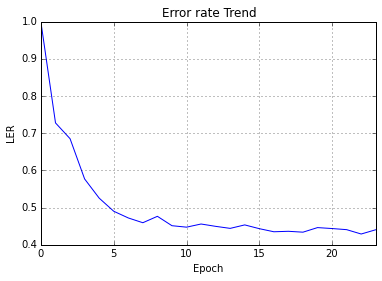

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.__version__
%matplotlib inline

print len(model2L_Noise_momemtumClip_bottleneckfea.train_history_)
histo = pd.DataFrame(model2L_Noise_momemtumClip_bottleneckfea.train_history_)

print histo
print histo['LER'].describe()

my_plot = histo['LER'].plot(title="Error rate Trend",legend=None)
my_plot.set_xlabel("Epoch")
my_plot.set_ylabel("LER")


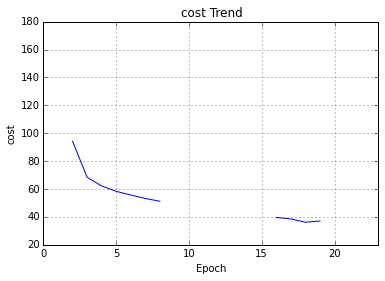

In [15]:
my_plot2 = histo['cost'].plot(title="cost Trend",legend=None)
my_plot2.set_xlabel("Epoch")
my_plot2.set_ylabel("cost")


In [16]:
histo.to_pickle('./ver1-L2-010-noise-Gclip-bucketfea.pa')

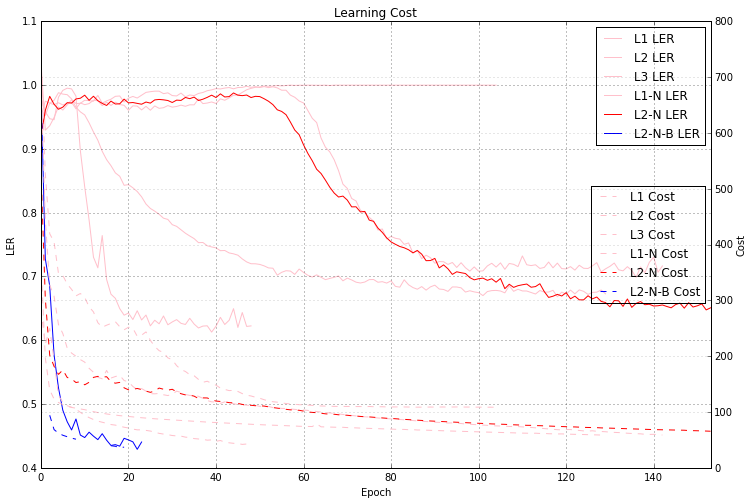

In [20]:
# ref : http://stackoverflow.com/questions/16568964/make-a-multiline-plot-from-csv-file-in-matplotlib
# ref : http://pbpython.com/simple-graphing-pandas.html

l1histo = pd.read_pickle('./ver1-L1-313-nonoise.pa')
l2histo = pd.read_pickle('./ver1-L2-313-nonoise.pa')
l3histo = pd.read_pickle('./ver1-L3-313-nonoise.pa')
# l4histo = pd.read_pickle('./ver1-L1-313-noise.pa')
l4histo = pd.read_pickle('./ver1-L2-313-noise-Gclip.pa')
l5histo = pd.read_pickle('./ver1-L2-313-noise.pa')
l6histo = pd.read_pickle('./ver1-L2-010-noise-Gclip-bucketfea.pa')

my_plot3 = l1histo['LER'].plot(label="L1 LER", color='Pink',legend=True, figsize=(12, 8), sharex=True)
my_plot3 = l2histo['LER'].plot(label="L2 LER", color='Pink',legend=True)
my_plot3 = l3histo['LER'].plot(label="L3 LER", color='Pink',legend=True)
my_plot3 = l4histo['LER'].plot(label="L1-N LER", color='Pink',legend=True)
my_plot3 = l5histo['LER'].plot(label="L2-N LER", color='r',legend=True)

my_plot3 = l6histo['LER'].plot(label="L2-N-B LER", color='b',legend=True)

plt.legend(loc='best')
my_plot3.set_xlabel("Epoch")
my_plot3.set_ylabel("LER")

# color deck r,g,b,k,Pink
my_plot3 = l1histo['cost'].plot(secondary_y=True, style='--', color='Pink', label="L1 Cost",legend=True)
my_plot3 = l2histo['cost'].plot(secondary_y=True, style='--', color='Pink', label="L2 Cost",legend=True)
my_plot3 = l3histo['cost'].plot(secondary_y=True, style='--', color='Pink', label="L3 Cost",legend=True)
my_plot3 = l4histo['cost'].plot(secondary_y=True, style='--', color='Pink', label="L1-N Cost",legend=True)
my_plot3 = l5histo['cost'].plot(secondary_y=True, style='--', color='r', label="L2-N Cost",legend=True)

my_plot3 = l6histo['cost'].plot(secondary_y=True, style='--', color='b', label="L2-N-B Cost",legend=True)

my_plot3.set_xlabel("Epoch")
my_plot3.set_ylabel("Cost")
plt.title("Learning Cost")
plt.grid(alpha=0.4) 
plt.legend(loc='center right')
# plt.add_legend()
fig = my_plot3.get_figure()
fig.savefig("ver2_L1toL3_withNoise2_charAnal.png")


In [22]:
label_error_rate = 0.
pr_error_rate = 0.
wr_error_rate = 0.
pr_count = 0
print len(x_test)

WRITE_RESULT = "./dataCebuano/large_dev_predict_result_2L_noise_GClip_with010_epo24.trans"

with open(WRITE_RESULT, 'w+') as f:
    for index in range( len(x_test) ) :
        prepre = model2L_Noise_momemtumClip_bottleneckfea.predict( x_test[index])
        ## print actual
        y_actual = decode_all_actual( y_test[index], y_test_mask[index], batch_size , True)
        ## print pred
        y_predict = decode_all_pred( np.argmax(prepre[0],axis=2) , x_test_mask[index],  batch_size , False)
        for a, b in zip( y_actual, y_predict):
            # print "---------"
            # print "Target : ", a
            # print "Predict: ", b
            # print _count_grade(a,b)
            pr_error_rate += _count_grade( a, b)
            wr_error_rate += wer( a.split(' '), b.split(' ') )
            f.write(idCollect[pr_count])
            f.write(' ')
            f.write(b);
            f.write('\n');
            pr_count += 1
        
        label_error_rate += check_all( y_test[index], y_test_mask[index],
                         np.argmax(prepre[0],axis=2), x_test_mask[index],
                         batch_size) 

    label_error_rate /= len(x_test)
    pr_error_rate /= pr_count
    wr_error_rate /= pr_count
    print "Total Sentence : ", pr_count
    print "chun label_error_rate : ", label_error_rate
    print "Lees label_error_rate : ", pr_error_rate
    print "true word_errir_rate : ", wr_error_rate

print "Mission Complete"

'''
iter 119
103
Total Sentence :  4120
chun label_error_rate :  0.728992975104
Lee's label_error_rate :  0.728992975104
Mission Complete

'''


226
Total Sentence :  9040
chun label_error_rate :  0.680572579989
Lees label_error_rate :  0.680572579989
true word_errir_rate :  1.06700331261
Mission Complete


"\niter 119\n103\nTotal Sentence :  4120\nchun label_error_rate :  0.728992975104\nLee's label_error_rate :  0.728992975104\nMission Complete\n\n"

In [95]:
# N-Gram

import nltk 
from nltk.util import ngrams
'''
>> train_toks = TaggedTokenizer().tokenize(tagged_text_str)
>>> tagger = NthOrderTagger(3) # 3rd order tagger
>>> tagger.train(train_toks)
'''
TRAINING_LABELS = './dataCebuano/train.txt'

with open( TESTING_LABELS, 'r') as f:
        specific = '?'
        checkPara = 0
        for lines in f:
            yWithId = lines.split('\n')[0].split(' ', 1)
            curword = ""
            judgeSpecific = False
            for char in yWithId[1] :
                if char == '(' and checkPara == 0 : 
                    checkPara = 3
                elif checkPara > 0 :
                    checkPara -= 1
                    if checkPara == 0 :
                        curword += specific
                else :
                    if char == '<' :
                        judgeSpecific = True;                
                    if( judgeSpecific ):
                        if char == '>':
                            curword += specific
                            judgeSpecific = False
                    else :
                        curword += char.lower()
        bigrams=ngrams(curword,2)
        print curword.split(' ')
        print bigrams
# Not finish implement Im wondering how to use a ngram
        
    
   

['dakua', "gani'", 'imo', 'nga', 'tingog', "dako'", 'kaayo', 'na', "ako'", 'nga', 'tingog']
<generator object ngrams at 0x7f305f96e820>


In [35]:
# Beam Search 
# Here we count word error rate

import operator

def allMaxDict( oldD, newD ) :
    oMax = max(oldD.iteritems(), key=operator.itemgetter(1))[0]
    count = 0
    for nv in newD : 
        if nv > oMax:
            count += 1
    return count

beamWidth = 100
# ------- Total Batch Data
for index in range( len(x_test) ) :
    y_actual = decode_all_actual( y_test[index], y_test_mask[index], batch_size , True)
    prepre = model2L_Noise_momemtumClip_bottleneckfea.predict( x_test[index] )

# ------- Each Every Batch
    for i in xrange(batch_size) :
        idmask = np.swapaxes( y_test_mask[index], 0, 1) [i]
        idseq = prepre[0][i] # [0][] for implementation issue, take each batch( one id with extra blank )
        
        beamCollect = {}
        
# ------- Each Sequence
        for t in np.nonzero(idmask)[0] :
            if t == 0 :
                for cc in range( len(idseq[t]) ) :
                    beamCollect[ char_unMap[cc] ] = idseq[t][cc]
            else : 
                lastBeamColloect = beamCollect
                toRemove = beamCollect
                beamCollect = {}
                while allMaxDict(lastBeamColloect, beamCollect) < beamWidth :
                    yStar = max(toRemove.iteritems(), key=operator.itemgetter(1))[0]
                    yStarProp = toRemove[yStar]
                    toRemove.pop(yStar, None)

                    # add each word
                    for cc in range( len(idseq[t]) ) :
                        yCatCC = yStar + char_unMap[cc]
                        yCatCCProp = yStarProp * idseq[t][ cc ] 
                        beamCollect[ yCatCC ] = yCatCCProp
            
            # remove all but W most probable 
            sorted_beamCollect = sorted(beamCollect.items(), key=operator.itemgetter(1))
            for sk, sv in sorted_beamCollect :
                if len(beamCollect) <= beamWidth :
                    break
                else :
                    beamCollect.pop(sk, None)
        
        # Now we get the result of beamsearch dict [ seq, prop ]
        
        #print "Result is : ( wer \ answer ) "
        for rk in beamCollect : # result key
            # print beamCollect[rk], '\t', rk, '\t', clean_up(rk), '\t', wer( rk.split(' '), y_actual[i] )
            rr = clean_up(rk)
            grade = wer(  y_actual[i].split(' '), rr.split(' '))
            if grade < 0.5:
                print grade , '\t', rr
                print "Actual Answer :", y_actual[i]
         
        #print "Actual Answer :", y_actual[i]
            
        # break # test sequence 
    # break # test Batch
print 'end'


0.0 	ha
Actual Answer : ha
0.0 	ha
Actual Answer : ha
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	na
Actual Answer : na
0.0 	ha
Actual Answer : ha
0.0 	ha
Actual Answer : ha
0.0 	ha
Actual Answer : ha
0.0 	ha
Actual Answer : ha
0.0 	ha
Actual Answer : ha
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	ha
Actual Answer : ha
0.0 	ha
Actual Answer : ha
0.0 	ha
Actual Answer : ha
0.0 	uo
Actual Answer : uo
0.0 	ha
Actual Answer : ha
0.0 	ha
Actual Answer : ha
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	ha
Actual Answer : ha
0.0 	ha
Actual Answer : ha
0.0 	oh
Actual Answer : oh
0.0 	oh
Actual Answer : oh
0.0 	uo
Actual Answer : uo
0.0 	uo
Actual Answer : uo
0.0 	ha
Actual Answer : ha
0

KeyboardInterrupt: 

In [ ]:
''' 
[ Doing : ]
    - Read character from *.txt to build the corpus 

[ Result : ]

-- Without Develope Data:

Building corpus without develope data:
set([' ', "'", '-', '?', '_', 'a', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'h', 'k', 'j', 'm', 'l', 'o', 'n', 'q', 'p', 's', 'r', 'u', 't', 'w', 'v', 'y', 'x', 'z'])
Total len is : 31
Done Write to [./dataCebuano/corpus.txt]

-- With Develope Data:

Building corpus with develope data:
set([' ', "'", ')', '(', '-', '?', '_', 'a', 'c', 'b', 'e', 'd', 'g', 'f', 'i', 'h', 'k', 'j', 'm', 'l', 'o', 'n', 'q', 'p', 's', 'r', 'u', 't', 'w', 'v', 'y', 'x', 'z'])
Total len is : 33
Done Write to [./dataCebuano/corpus.txt]
'''

TRAINING_LABEL = "./dataCebuano/train.txt"
DEVELOPE_LABEL = "./dataCebuano/dev.txt"
WRITING_TO = "./dataCebuano/corpus.txt"

# Special part to build corpus
def buildCharacterCorpus(withDevelopeData = False) :
    corpus = set( )
    with open(TRAINING_LABEL, 'r') as ft:
        for lines in ft:
            for word in lines.split('\n')[0].split(' ')[1:]:
                if word[0] == '<':
                    # We take every <...> as <unk> 
                    unKnownTag = '?'
                    corpus.add( unKnownTag ) 
                else:
                    for char in word:
                        corpus.add(char.lower())
    
    if( withDevelopeData ) :
        with open(DEVELOPE_LABEL, 'r') as fd:
            for lines in fd:
                for word in lines.split('\n')[0].split(' ')[1:]:
                    if word[0] == '<':
                        unKnownTag = '?'
                        corpus.add( unKnownTag ) 
                        # corpus.add(word.split('\n')[0].lower())
                    else:
                        for char in word:
                            corpus.add(char.lower())
    
    corpus.add(' ')
    print "Building corpus with" + ("" if withDevelopeData else "out") + " develope data:"
    print corpus
    print "Total len is : " + str(len(corpus))
    
    
    with open(WRITING_TO, 'w+') as fw:
        for item in corpus:
            fw.write(item + '\n')        
    print "Done Write to [" + WRITING_TO + "]"
    return corpus

trainingCorpus = buildCharacterCorpus()



In [1]:
# import theano
# from theano import tensor as T
# from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
import numpy as np

from sklearn import cross_validation as cv
from sklearn import metrics
from sklearn import grid_search as gs
from sklearn.metrics import accuracy_score
from itertools import repeat

#proprocessor
from sklearn import preprocessing
from time import time

from itertools import repeat
import numpy as np
import random
from sklearn import preprocessing


def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def vectorized_result ( j , siz) :
    e = np.zeros((siz, 1))
    e[j] = 1.0
    return np.reshape( e, siz)

# TRAINING_DATA   = './dataCebuano/train.f0_ffv_fbank.fea'
# TEST_DATA = './dataCebuano/dev.f0_ffv_fbank.fea'
# TRAIN_ARK  = './dataCebuano/train_Normalized_SELFVALID.ark'

#TEST_ARK  = './dataCebuano/dev_Normalized_SELFVALID_LenLessThen500.ark'

TEST_DATA = './dataCebuano/tlkagk/large_dev.dnn.fea'
# VALIDATION_DATA = './dataCebuano/dev.f0_ffv_fbank.fea'
TEST_ARK  = './dataCebuano/tlkagk/large_dev.dnn.fea.lessThen500.ark'
# TRAIN_ARK  = './dataCebuano/train_Normalized_SELFVALID_LenLessThen600.ark'


def normalizeAndFilterData ( maxLength = 3000) :
    # Dataset
    x_data = []
    x_name = []
    record_seq = []

    with open( TEST_DATA, 'r') as f:
        for lines in f: 
            if '[' in lines :
                id = lines.split(' ')[0]
                x_name.append(id)
                seq = 0
            elif ']' in lines :
                if seq > maxLength :
                    x_name.pop()
                    del x_data[-seq:]
                else :
                    seq += 1
                    record_seq.append(seq)
                    x_data.append([float(x) for x in lines.split(' ') [2:-1] ])
            else :
                seq += 1
                x_data.append([float(x) for x in lines.split(' ') [2:-1] ])

    print "Normalized"
    x_data = preprocessing.scale( np.array(x_data) )

    # x_data[separate+1]
    # x_name
    bitch = record_seq.index(max(record_seq))
    print "Max len is ", record_seq[bitch]
    
    print "Total training data", len(x_name)

    # trainF = open(TRAIN_ARK, 'w+')
    with open(TEST_ARK, 'w+') as trainF:
        currentSeq = 0
        for nameIndex in range( len(x_name) ):

            trainF.write(str(x_name[nameIndex])+"  [\n")

            for valueIndex in range( (record_seq[nameIndex]) ):
                for featureIndex in range( len(x_data[0]) ):
                    if ( featureIndex+1) != len(x_data[0] ) :
                        trainF.write( str(x_data[ currentSeq  + valueIndex][featureIndex]) + " ")
                    else:
                        trainF.write( str(x_data[ currentSeq  + valueIndex][featureIndex]) )
                if valueIndex+1 == (record_seq[nameIndex]):
                    trainF.write(" ]\n")
                else:
                    trainF.write("\n")
            currentSeq += record_seq[nameIndex]

    print "MIssion ComplEte"


normalizeAndFilterData(500)


Normalized
Max len is  501
Total training data 9068
MIssion ComplEte


In [ ]:
# This block is to do the viterbi algorithm 

# Here we count word error rate
for index in range( len(x_test) ) :
    prepre = model2L_Noise_with313.predict( x_test[index] )
    for i in xrange(batch_size) :
        # Process Every Batch
        idmask = np.swapaxes( y_test_mask[index], 0, 1) [i]
        idseq = prepre[0][i] # [0] for implementation issue, take each batch( one id with extra blank )

        viterbiDelta = []
        viterbiBackTracking = []
        
        for t in np.nonzero(idmask)[0] :
            # Process Every Sequence 
            delta = []
            backTrack = []
            if t == 0:
                for c in idseq[t] :
                    delta.append( c )
                    backTrack.append( -1 )
            else :
                for c in idseq[t]:
                    multiply = [ last * c for last in viterbiDelta[t-1] ]
                    delta.append( max(multiply) )
                    backTrack.append( multiply.index(max(multiply)) )
            viterbiDelta.append( delta )  
            viterbiBackTracking.append( backTrack )
        
        
        bestAns = ""
        lastT = len(viterbiDelta) - 1
        lastChar = viterbiDelta[lastT].index( max( viterbiDelta[lastT] ) )
        
        while lastChar != -1 :
            bestAns = char_unMap[ lastChar ] + bestAns
            lastChar = viterbiBackTracking[lastT][lastChar]
            lastT -= 1
        
        bestAns = clean_up( bestAns )
        
        # Not Viterbi, multiply all max probability 
        ans =np.argmax(prepre[0],axis=2)[i]
        result = remap_back( ans[np.nonzero(idmask)] , False )
        
        if bestAns != result : 
            print "???"
        print "-------------------"
        print "Viterbi, cleanup : ", bestAns
        print "multipl, cleanup : ", result
        
    break
print 'end'

